<a href="https://colab.research.google.com/github/razerspeed/image_recommendation_task/blob/main/age_gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading dataset**


In [1]:
!pip install torchsummary

In [2]:
#original dataset link
#https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv
!gdown https://drive.google.com/uc?id=1ARqd0MkAresv6QpL1YNLRcg3lVvLXGPH

Downloading...
From: https://drive.google.com/uc?id=1ARqd0MkAresv6QpL1YNLRcg3lVvLXGPH
To: /content/archive.zip
66.3MB [00:00, 127MB/s]


In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: age_gender.csv          


In [4]:
import pandas as pd
data_csv = pd.read_csv('age_gender.csv')
print(data_csv['age'].unique()) #1~116
print(data_csv['ethnicity'].unique()) #0~4
data_csv.head()

[  1  10 100 101 103 105  11 110 111 115 116  12  13  14  15  16  17  18
  19   2  20  21  22  23  24  25  26  27  28  29   3  30  31  32  33  34
  35  36  37  38  39   4  40  41  42  43  44  45  46  47  48  49   5  50
  51  52  53  54  55  56  57  58  59   6  60  61  62  63  64  65  66  67
  68  69   7  70  71  72  73  74  75  76  77  78  79   8  80  81  82  83
  84  85  86  87  88  89   9  90  91  92  93  95  96  99]
[2 3 4 0 1]


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
def age_cvt(age) :
    return int(age/5)

data_csv['age'] = data_csv['age'].apply(lambda x : age_cvt(x))
data_csv.head()

,age,ethnicity,gender,img_name,pixels
0,0,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,0,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,0,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,0,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,0,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


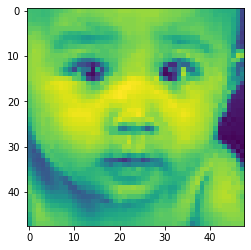

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_csv['pixels'] = data_csv['pixels'].apply(lambda x : np.array(x.split(), dtype="float32"))
data_csv['pixels'] = data_csv['pixels'] / 255.0

plt.imshow(data_csv['pixels'][0].reshape(48, 48)) #2304 = 48*48
plt.show()

In [8]:
test_list = [4, 504, 1004, 2504, 5004, 6904, 17894, 18644, 20004, 23014]

print(len(data_csv))

test_csv = pd.DataFrame()
for i in test_list :
    test_csv = test_csv.append(data_csv.iloc[i])
    data_csv = data_csv.drop(i)

print(len(data_csv))
test_csv.head()

23705
23695


,age,ethnicity,gender,img_name,pixels
4,0.0,2.0,0.0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."
505,0.0,2.0,0.0,20161219161941534.jpg.chip.jpg,"[0.8117647, 0.8117647, 0.8039216, 0.8, 0.78823..."
1006,0.0,2.0,1.0,20161219162225422.jpg.chip.jpg,"[0.0, 0.003921569, 0.0, 0.003921569, 0.0431372..."
2507,3.0,0.0,1.0,20170109213935367.jpg.chip.jpg,"[0.1254902, 0.12156863, 0.14117648, 0.11372549..."
5008,4.0,1.0,0.0,20170102233456210.jpg.chip.jpg,"[0.6666667, 0.62352943, 0.5568628, 0.6392157, ..."


# **Creating CNN Model**

In [9]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import cv2
import numpy as np

class dataset(Dataset) :
    def __init__(self, age_label, eth_label, gen_label, img) :
        self.age_label = np.array(age_label)
        self.eth_label = np.array(eth_label)
        self.gen_label = np.array(gen_label)
        self.img = np.array(img)
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
    def __len__(self) :
        return len(self.img)
    
    def __getitem__(self, index) :
        age_label = self.age_label[index]
        eth_label = self.eth_label[index]
        gen_label = self.gen_label[index]
        
        img = self.img[index].reshape(48, 48, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = self.transform(img)
        
        return img, age_label, eth_label, gen_label
    
train_data = dataset(data_csv['age'][:], data_csv['ethnicity'][:], 
                     data_csv['gender'][:], data_csv['pixels'][:])
train_data = DataLoader(train_data, batch_size = 128, shuffle = True)

In [10]:
age_features = len(data_csv['age'].unique())
eth_features = len(data_csv['ethnicity'].unique())
gen_features = len(data_csv['gender'].unique())

print(age_features, eth_features, gen_features)

24 5 2


In [12]:
import torch.nn as nn

from torchsummary import summary

class MultiLabelCNN(nn.Module) :
    def __init__(self, age_features, ethnicity_features, gender_features) :
        super().__init__()   

        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #24
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #12
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #6
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #3
            #nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )
        
        self.dnnModel = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
        )
        
        self.age_classifier = nn.Linear(32, age_features)
        self.eth_classifier = nn.Linear(32, ethnicity_features)
        self.gen_classifier = nn.Linear(32, gender_features)     
    def forward(self, x) :

        output = self.cnnModel(x)
        output = output.squeeze()
        output = self.dnnModel(output)
        
        age = self.age_classifier(output)
        eth = self.eth_classifier(output)
        gen = self.gen_classifier(output)
        return age, eth, gen
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(age_features, eth_features, gen_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def custom_loss (output, target) :
    age_loss = nn.CrossEntropyLoss().to(device)(output[0], target[0])
    eth_loss =  nn.CrossEntropyLoss().to(device)(output[1], target[1])
    gen_loss =  nn.CrossEntropyLoss().to(device)(output[2], target[2])
    
    return age_loss + eth_loss + gen_loss, age_loss.item(), eth_loss.item(), gen_loss.item()

summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
         LeakyReLU-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
         MaxPool2d-5           [-1, 64, 12, 12]               0
         LeakyReLU-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         MaxPool2d-8            [-1, 128, 6, 6]               0
         LeakyReLU-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 256, 6, 6]         295,168
        MaxPool2d-11            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
           Linear-13                  [-1, 128]          32,896
        LeakyReLU-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# **Training and Testing**

In [13]:
from tqdm.notebook import tqdm

epoch_num = 100
model.train()

for epoch in range(epoch_num) :
    epoch_loss = 0
    epoch_acc = 0
    for img, age, eth, gen in tqdm(train_data) :
        img = img.to(device)
        age = age.to(device)
        eth = eth.to(device)
        gen = gen.to(device)
        
        predict = model(img)
        
        loss = custom_loss(predict, (age, eth, gen))
        
        optimizer.zero_grad()
        loss[0].backward()
        optimizer.step()
        
        correct_prediction = 0
        for i, _ in enumerate(age) :
            if torch.argmax(predict[0][i]) == age[i] and \
            torch.argmax(predict[1][i]) == eth[i] and \
            torch.argmax(predict[2][i]) == gen[i] :
                correct_prediction += 1
                
        epoch_loss += loss[0]
        epoch_acc += correct_prediction / img.shape[0]
        
    epoch_loss = epoch_loss / len(train_data)
    epoch_acc = epoch_acc / len(train_data)
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, epoch_num, epoch_loss, epoch_acc))
    
    if epoch_acc > 0.93 and epoch_loss < 0.2 :
        print('early stop')
        break

  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 1/100,   loss : 4.69921,    acc : 0.04066


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 2/100,   loss : 4.28696,    acc : 0.06927


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 3/100,   loss : 3.85229,    acc : 0.10637


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 4/100,   loss : 3.50352,    acc : 0.14008


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 5/100,   loss : 3.25280,    acc : 0.16746


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 6/100,   loss : 3.06665,    acc : 0.18568


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 7/100,   loss : 2.93700,    acc : 0.20370


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 8/100,   loss : 2.86169,    acc : 0.21391


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 9/100,   loss : 2.76706,    acc : 0.22359


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 10/100,   loss : 2.68320,    acc : 0.23630


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 11/100,   loss : 2.61004,    acc : 0.24459


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 12/100,   loss : 2.54481,    acc : 0.25045


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 13/100,   loss : 2.50287,    acc : 0.25645


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 14/100,   loss : 2.43811,    acc : 0.26416


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 15/100,   loss : 2.41898,    acc : 0.26790


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 16/100,   loss : 2.34307,    acc : 0.28209


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 17/100,   loss : 2.31538,    acc : 0.28662


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 18/100,   loss : 2.27761,    acc : 0.29222


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 19/100,   loss : 2.21298,    acc : 0.30083


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 20/100,   loss : 2.17167,    acc : 0.31062


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 21/100,   loss : 2.12090,    acc : 0.31486


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 22/100,   loss : 2.08986,    acc : 0.32622


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 23/100,   loss : 2.05078,    acc : 0.33267


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 24/100,   loss : 1.99160,    acc : 0.34042


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 25/100,   loss : 1.95286,    acc : 0.34809


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 26/100,   loss : 1.91749,    acc : 0.36098


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 27/100,   loss : 1.85133,    acc : 0.37186


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 28/100,   loss : 1.82501,    acc : 0.37364


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 29/100,   loss : 1.78982,    acc : 0.38061


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 30/100,   loss : 1.75821,    acc : 0.39097


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 31/100,   loss : 1.69874,    acc : 0.40811


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 32/100,   loss : 1.64433,    acc : 0.42004


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 33/100,   loss : 1.61440,    acc : 0.42850


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 34/100,   loss : 1.60941,    acc : 0.42858


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 35/100,   loss : 1.52926,    acc : 0.45225


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 36/100,   loss : 1.46279,    acc : 0.46675


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 37/100,   loss : 1.43613,    acc : 0.48035


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 38/100,   loss : 1.40047,    acc : 0.49024


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 39/100,   loss : 1.34137,    acc : 0.50719


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 40/100,   loss : 1.33284,    acc : 0.50477


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 41/100,   loss : 1.27999,    acc : 0.52809


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 42/100,   loss : 1.25919,    acc : 0.53091


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 43/100,   loss : 1.19768,    acc : 0.55527


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 44/100,   loss : 1.13590,    acc : 0.57348


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 45/100,   loss : 1.15497,    acc : 0.57177


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 46/100,   loss : 1.10961,    acc : 0.58893


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 47/100,   loss : 1.03176,    acc : 0.61254


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 48/100,   loss : 0.99104,    acc : 0.62600


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 49/100,   loss : 0.97690,    acc : 0.63102


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 50/100,   loss : 0.96475,    acc : 0.64104


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 51/100,   loss : 0.91678,    acc : 0.65767


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 52/100,   loss : 0.87488,    acc : 0.66949


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 53/100,   loss : 0.86853,    acc : 0.67390


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 54/100,   loss : 0.79912,    acc : 0.70278


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 55/100,   loss : 0.84469,    acc : 0.68575


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 56/100,   loss : 0.79941,    acc : 0.70274


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 57/100,   loss : 0.73038,    acc : 0.72836


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 58/100,   loss : 0.68001,    acc : 0.75077


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 59/100,   loss : 0.68410,    acc : 0.74857


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 60/100,   loss : 0.67552,    acc : 0.74911


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 61/100,   loss : 0.66012,    acc : 0.76161


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 62/100,   loss : 0.62365,    acc : 0.77429


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 63/100,   loss : 0.63244,    acc : 0.77108


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 64/100,   loss : 0.66795,    acc : 0.75738


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 65/100,   loss : 0.54742,    acc : 0.80769


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 66/100,   loss : 0.54255,    acc : 0.80613


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 67/100,   loss : 0.56458,    acc : 0.79651


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 68/100,   loss : 0.53927,    acc : 0.80844


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 69/100,   loss : 0.56322,    acc : 0.79792


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 70/100,   loss : 0.48588,    acc : 0.82823


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 71/100,   loss : 0.43762,    acc : 0.84805


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 72/100,   loss : 0.48426,    acc : 0.83196


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 73/100,   loss : 0.50244,    acc : 0.82539


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 74/100,   loss : 0.52079,    acc : 0.81758


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 75/100,   loss : 0.42856,    acc : 0.85406


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 76/100,   loss : 0.36158,    acc : 0.87827


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 77/100,   loss : 0.46988,    acc : 0.84011


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 78/100,   loss : 0.44160,    acc : 0.85099


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 79/100,   loss : 0.35766,    acc : 0.88020


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 80/100,   loss : 0.41438,    acc : 0.85964


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 81/100,   loss : 0.37383,    acc : 0.87172


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 82/100,   loss : 0.41689,    acc : 0.85723


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 83/100,   loss : 0.30695,    acc : 0.89888


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 84/100,   loss : 0.37578,    acc : 0.87412


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 85/100,   loss : 0.32861,    acc : 0.89001


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 86/100,   loss : 0.35144,    acc : 0.88544


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 87/100,   loss : 0.29432,    acc : 0.90350


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 88/100,   loss : 0.39032,    acc : 0.86895


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 89/100,   loss : 0.33991,    acc : 0.88716


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 90/100,   loss : 0.31234,    acc : 0.89667


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 91/100,   loss : 0.27217,    acc : 0.91177


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 92/100,   loss : 0.29872,    acc : 0.89976


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 93/100,   loss : 0.30533,    acc : 0.89908


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 94/100,   loss : 0.28614,    acc : 0.90805


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 95/100,   loss : 0.32490,    acc : 0.89504


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 96/100,   loss : 0.24465,    acc : 0.92355


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 97/100,   loss : 0.32988,    acc : 0.89027


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 98/100,   loss : 0.31985,    acc : 0.89587


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 99/100,   loss : 0.29238,    acc : 0.90320


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 100/100,   loss : 0.19764,    acc : 0.94098
early stop


10


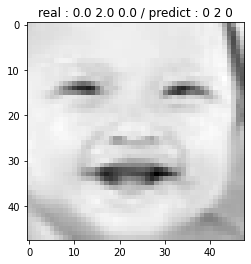

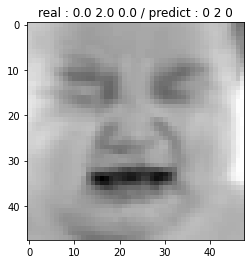

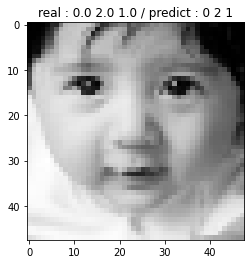

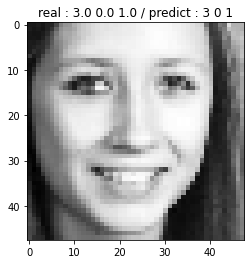

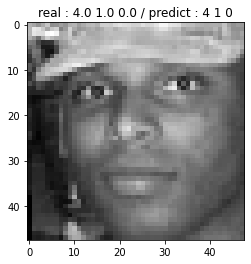

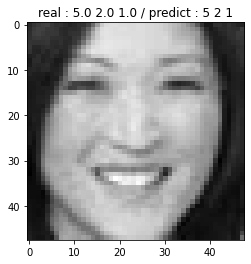

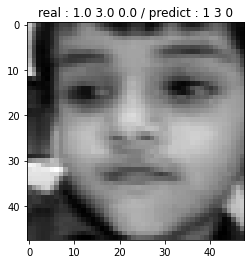

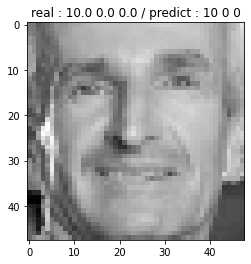

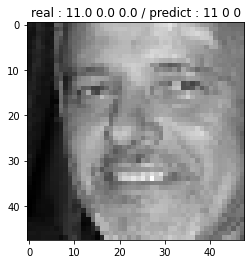

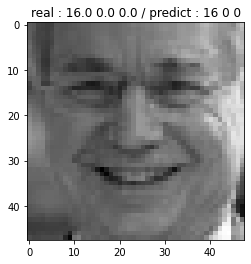

total_acc :  1.0


In [27]:
model.eval()

test_data = dataset(test_csv['age'][:], test_csv['ethnicity'][:], \
                     test_csv['gender'][:], test_csv['pixels'][:])
test_data = DataLoader(test_data, batch_size = 1, shuffle = False)
print(len(test_data))

correct_prediction = 0
for img, age, eth, gen in test_data :
    img = img.to(device)
    age = age.to(device)
    eth = eth.to(device)
    gen = gen.to(device)
    
    predict = model(img)
    
    real = str(age[0].item()) + ' ' + str(eth[0].item()) + ' ' + str(gen[0].item())
    pred = str(torch.argmax(predict[0]).item()) + ' ' + \
    str(torch.argmax(predict[1]).item()) + ' ' + str(torch.argmax(predict[2]).item())
    
    img = img.reshape(1, 48, 48).to('cpu').numpy()
    plt.imshow(img.reshape(48, 48),cmap='gray')
    plt.title('real : ' + str(real) + ' / predict : ' + str(pred))
    plt.show()
    
    if age[0] == torch.argmax(predict[0]) and \
    eth[0] == torch.argmax(predict[1]) and \
    gen[0] == torch.argmax(predict[2]) : correct_prediction += 1

print('total_acc : ', str(correct_prediction / len(test_data)))